In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
import os

%matplotlib notebook

In [33]:
from bs4 import BeautifulSoup

In [83]:
### Main Processsing Code


main_origins = set()
main_destinations = set()


df = pd.DataFrame()

directory = 'html'
earliest_departure = datetime.strptime('01JUN 2017 12:01PM', '%d%b %Y %I:%M%p')

# directory = 'return'
# earliest_departure = datetime.strptime('04JUN 2017 9:00PM', '%d%b %Y %I:%M%p')
# latest_arrival = datetime.strptime('06JUN 2017 9:00AM', '%d%b %Y %I:%M%p')

## Loop over HTML files, convert to DataFrame
for fn in os.listdir(directory):
    if fn[-5:] == '.html':
        print(fn)
        
        fullpath = os.path.join(directory, fn)
        
        df = df.append(pd.read_html(fullpath, attrs={'id': 'flightsOut'})[0], ignore_index=True)
        
        # Get Origin / Destination from HTML
        with open(fullpath, 'rb') as html:
            soup = BeautifulSoup(html, 'lxml')

            origin = soup.find(id="fromAirport").get_attribute_list('value')[0]
            destination = soup.find(id="toAirport").get_attribute_list('value')[0]
            
            
            main_origins.add(origin)
            main_destinations.add(destination)

print('Origins:', main_origins)
print('Destinations:', main_destinations)


## Parse Raw DataFrame
parsed_df = df[['From', 'To', 'Aircraft']].copy()


k = 0
for n, row in df.iterrows():
    
    # Group flights by route
    if row['From'] in main_origins:
        k += 1
    
    parsed_df.loc[n, 'Group'] = k
    parsed_df.loc[n, 'flight_num'] = row['Flight'].split()[0]
    
    # Combine departure date/time
    datetime_object = datetime.strptime('{} 2017 {}'.format(row['Departure Date'], row['Departure Time']), '%d%b %Y %I:%M%p')
    parsed_df.loc[n, 'dep_datetime'] = datetime_object
    
    # Combine Arrival date/time
    datetime_object = datetime.strptime('{} 2017 {}'.format(row['Arrival Date'], row['Arrival Time']), '%d%b %Y %I:%M%p')
    parsed_df.loc[n, 'arr_datetime'] = datetime_object
    
    # Combine total available seats
    total_seats = {'av': 0, 'au':0, 'cap':0}
    
    for label, col in zip(['business', 'first', 'main'], ['BusinessAv/Au(Cap)', 'First ClassAv/Au(Cap)', 'Main CabinAv/Au(Cap)']):
        av, temp = row[col].split('/')
        au, temp2 = temp.split('(')
        cap = temp2.replace(')', '')
        
        seats = {'av': int(av), 'au':int(au), 'cap':int(cap)}
        
        for key in ['av', 'au', 'cap']:
            total_seats[key] = total_seats[key] + seats[key]
            
    for key in ['av', 'au', 'cap']:
        parsed_df.loc[n, 'total_{}'.format(key)] = total_seats[key]


## Remove routes with more than one layover
single_stop_df = pd.DataFrame()

for n, group in parsed_df.groupby('Group'):
    if group.shape[0] <= 2:
        single_stop_df = single_stop_df.append(group)
        
parsed_df = single_stop_df


## Create set of layover options
origins = set({})
destinations = set({})
layovers = set([])

for r, row in parsed_df.iterrows():
    origins.add(row.From)
    destinations.add(row.To)
    
    if row.From in main_origins:
        layovers.add(row.To)
    
    if row.To in main_destinations:
        layovers.add(row.From)
        
print(origins, destinations, layovers)


## Reduce dataframe to only unique flights
dedup_df = parsed_df.drop_duplicates('flight_num')


dedup_df = dedup_df[dedup_df.dep_datetime >= earliest_departure]
dedup_df = dedup_df[dedup_df.arr_datetime <= latest_arrival]

oak.html
sjc.html
sfo.html
Origins: {'AUS'}
Destinations: {'SFO', 'OAK', 'SJC'}
{'DTW', 'LAX', 'MSP', 'AUS', 'ATL', 'JFK', 'SLC'} {'DTW', 'LAX', 'MSP', 'ATL', 'SFO', 'JFK', 'SLC', 'OAK', 'SJC'} {'DTW', 'LAX', 'MSP', 'ATL', 'JFK', 'SLC'}


In [84]:
first_flights = pd.DataFrame()

for n, flight in dedup_df.iterrows():
    if flight.From in main_origins:
        first_flights = first_flights.append(flight, ignore_index=True)

first_flights = first_flights.sort_values('dep_datetime')

last_flights = pd.DataFrame()

for n, flight in dedup_df.iterrows():
    if flight.To in main_destinations:
        last_flights = last_flights.append(flight, ignore_index=True)

last_flights = last_flights.sort_values('arr_datetime')


def plot_flight(flight, line_count, c='c'):
    
    plt.plot([flight.dep_datetime, flight.arr_datetime], [line_count, line_count], '-', c=c, linewidth=flight.total_av/2, solid_capstyle='butt')
    
    t = ax.text(flight.dep_datetime, line_count, flight.From, ha="left", va="bottom")
    t = ax.text(flight.arr_datetime, line_count, flight.To, ha="right", va="bottom")
    
    desc_str = 'FN: {}, Av: {}'.format(flight.flight_num, flight.total_av)
    t = ax.text(flight.arr_datetime, line_count, desc_str, ha="right", va="top")

<IPython.core.display.Javascript object>


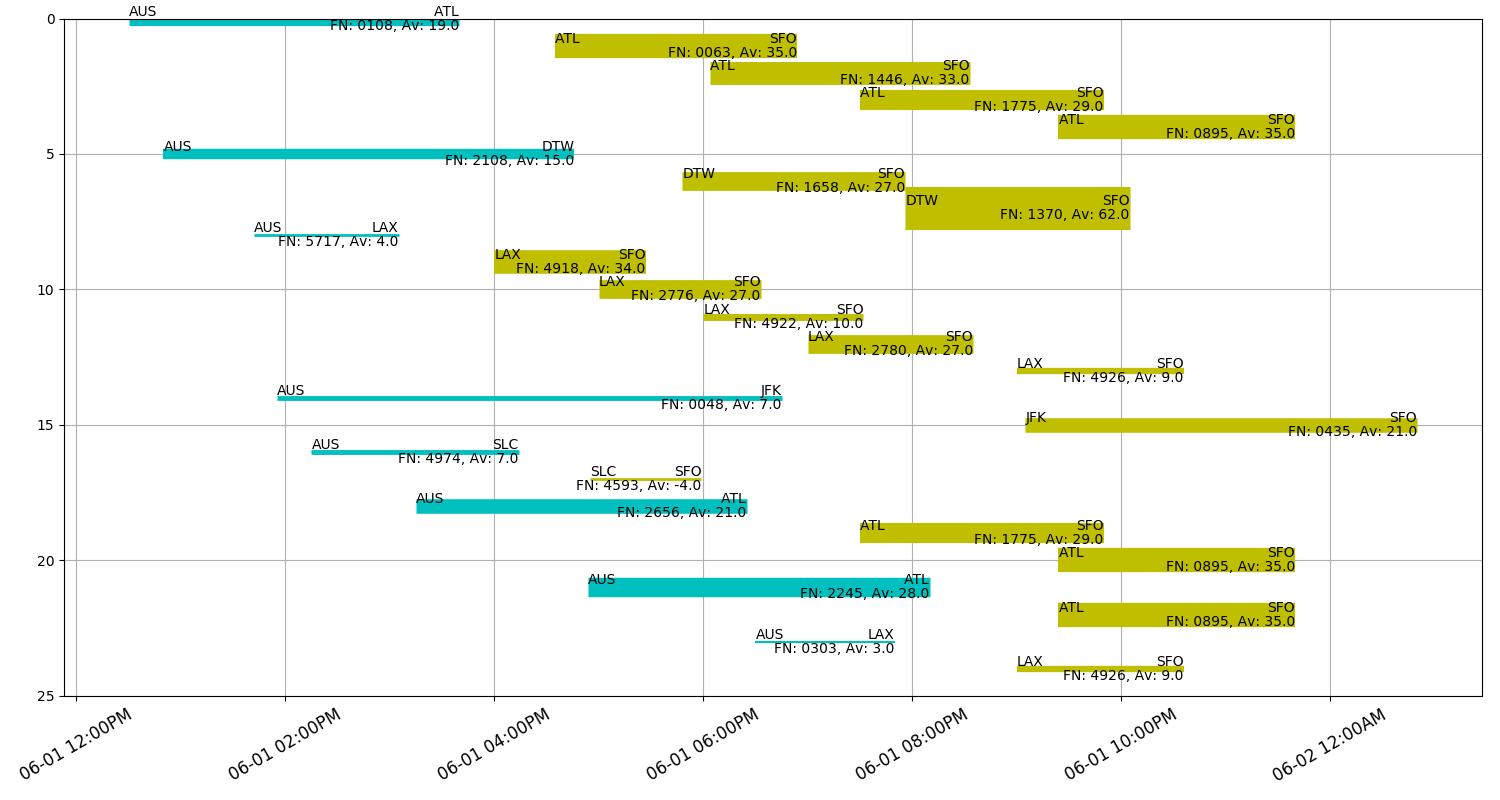

(25, 0)

In [92]:
### Outbound Flights first
plt.figure(figsize=[15,8])

ax = plt.gca()
    
myFmt = mdates.DateFormatter('%m-%d %I:%M%p')
ax.xaxis.set_major_formatter(myFmt)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=12)

line_count = 0
for n, flight in first_flights.iterrows():

    plot_flight(flight, line_count)
    line_count += 1
    
    connections = dedup_df[dedup_df.From == flight.To]
    connections = connections[connections.To == 'SFO']
    connections = connections[connections.dep_datetime >= flight.arr_datetime + timedelta(minutes=25)].sort_values('dep_datetime')

    for n, conn_flight in connections.iterrows():

        plot_flight(conn_flight, line_count, c='y')
        
        line_count += 1

plt.grid()
plt.tight_layout()

plt.ylim([line_count,0])

<IPython.core.display.Javascript object>


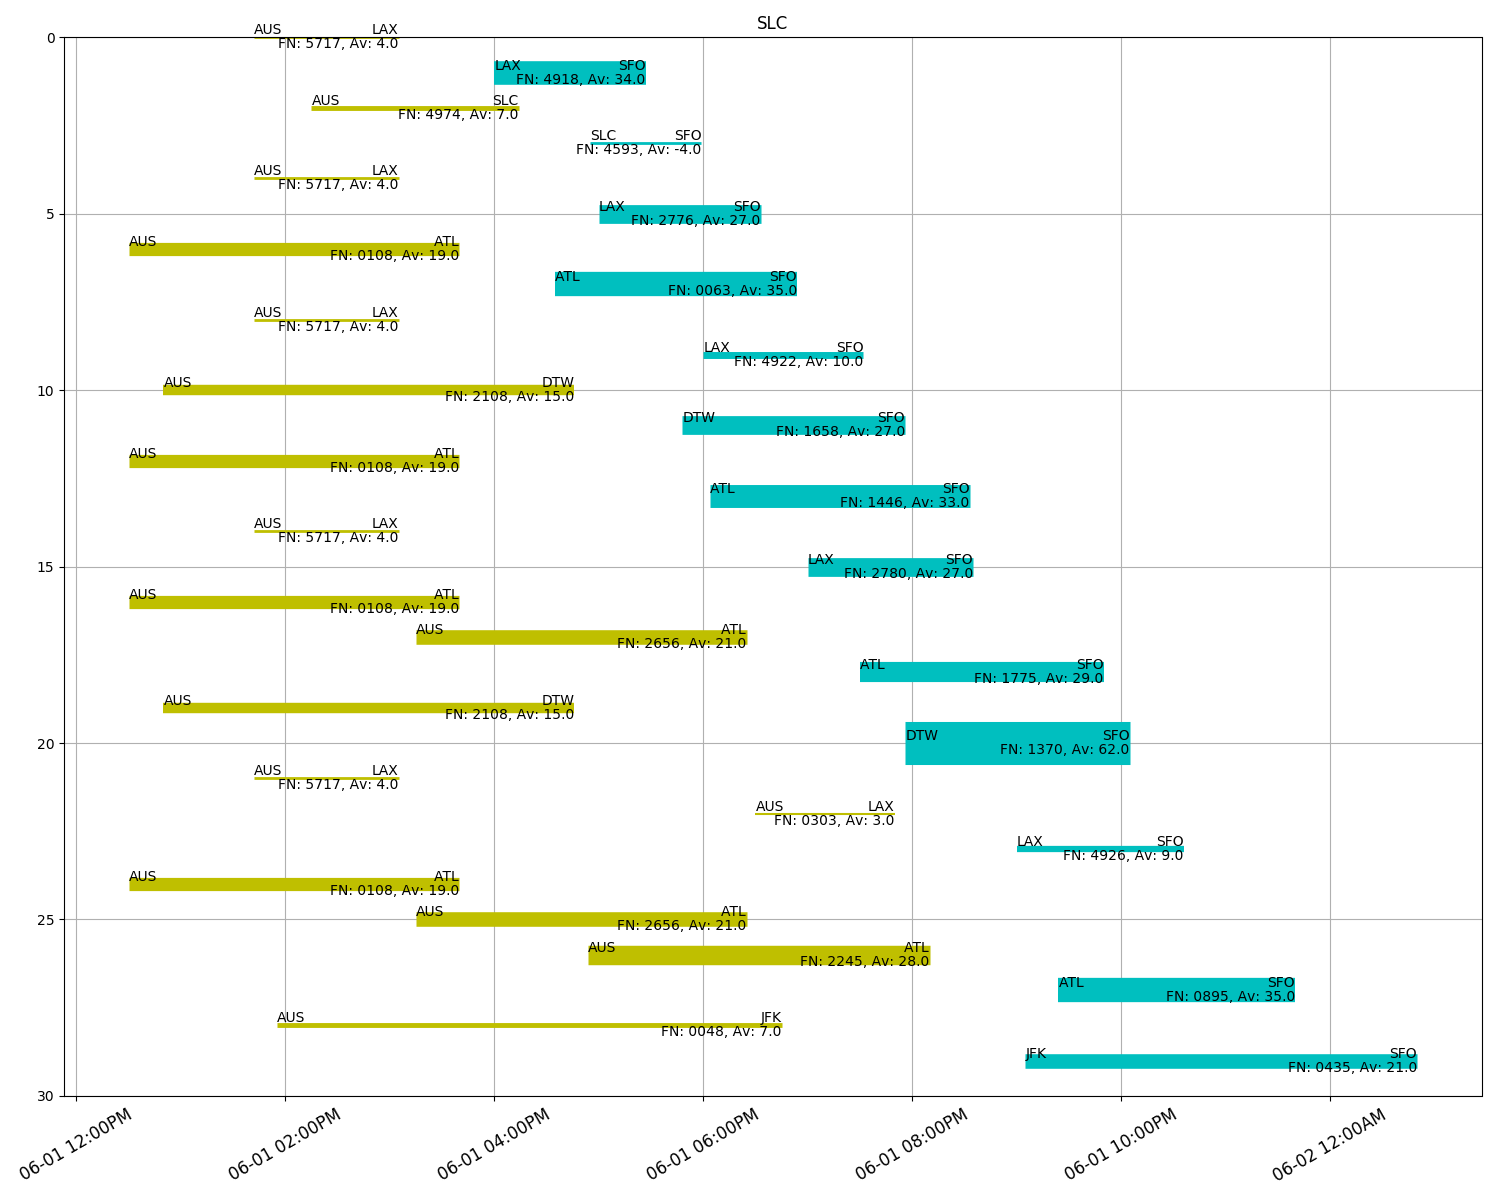

(30, 0)

In [90]:
### Arrival Flights first

plt.figure(figsize=[15,12])
plt.title(layover)

ax = plt.gca()

myFmt = mdates.DateFormatter('%m-%d %I:%M%p')
ax.xaxis.set_major_formatter(myFmt)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=12)

line_count = 0
k=0

last_flights = last_flights[last_flights.To == 'SFO']

for n, flight in last_flights.iterrows():


        connections = dedup_df[dedup_df.To == flight.From]
#         connections = connections[connections.To == 'SFO']
#         connections = connections[np.any([connections.To == 'ATL', connections.To == 'LAX'], axis=0)]

        connections = connections[connections.arr_datetime <= flight.dep_datetime - timedelta(minutes=25)].sort_values('dep_datetime')

        for n, conn_flight in connections.iterrows():

            plot_flight(conn_flight, line_count, c='y')

            line_count += 1

        if connections.shape[0] > 0:

            plot_flight(flight, line_count)
            line_count += 1


plt.grid()
plt.tight_layout()

plt.ylim([line_count,0])